In [10]:

from analyze import analyze_data
from utils import RequestData
import json
from datetime import datetime
from zoneinfo import ZoneInfo

def get_performance(report):
    loadgen_data = report['loadgen_data']

    total_request_count = len(loadgen_data)
    no_response_count = 0
    error_count = 0
    requests = []
    for request_data in loadgen_data:
        if 'error' not in request_data.keys():
            request = RequestData.init_from_dict(request_data)
            requests.append(request)
            continue

        if request_data == {'error': 'No response!'}:
            no_response_count += 1
        else:
            error_count += 1

    first_request_time = min(req.arrival_time for req in requests)
    cutoff_time = first_request_time + 60
    valid_requests = [req for req in requests if req.arrival_time >= cutoff_time]
    total_request_count = len(valid_requests)

    ttft_attain_count = 0
    tbt_attain_count = 0
    total_attain_count = 0
    for request in valid_requests:
        ttft_attain, tbt_attain = request.satisfy_SLO()
        if ttft_attain:
            ttft_attain_count += 1
        
        if tbt_attain:
            tbt_attain_count += 1
        
        if ttft_attain and tbt_attain:
            total_attain_count += 1

    ttft_attain_rate = ttft_attain_count / total_request_count
    tbt_attain_rate = tbt_attain_count / total_request_count
    total_attain_rate = total_attain_count / total_request_count

    # print(f"Among {total_request_count} requests, {ttft_attain_count} attain TTFT, {tbt_attain_count} attain TBT, {total_attain_count} attain total")
    # print(f"total attain rate: {total_attain_rate*100:.1f}%, TTFT attain rate: {ttft_attain_rate*100:.1f}%, TBT attain rate: {tbt_attain_rate*100:.1f}%")
    return ttft_attain_rate, tbt_attain_rate, total_attain_rate, cutoff_time

def get_cost(report, cutoff_time):

    req_counter = report['prom_data']
    metric_name = "router:ins_counter"
    start_str = report.get('router_start_time', 'N/A')
    end_str = report.get('router_end_time', 'N/A')
    tz_sg = ZoneInfo("Asia/Singapore")
    router_start_time = datetime.fromisoformat(start_str).replace(tzinfo=tz_sg).timestamp()
    router_end_time = datetime.fromisoformat(end_str).replace(tzinfo=tz_sg).timestamp()

    router_metrics = req_counter.get("router", {})
    cost_map = {}
    for i, (model_name, metrics) in enumerate(router_metrics.items()):
        req_counter_values = metrics.get(metric_name, [])
        req_counter_values = [
            t for t in req_counter_values 
            if float(t[0]) <= router_end_time and float(t[0]) >= cutoff_time
        ]
        cost_values = [float(t[1]) for t in req_counter_values]
        avg_cost = sum(cost_values) / len(cost_values) if cost_values else 0
        cost_map[model_name] = avg_cost
    return cost_map


def get_locality(report):
    same_node_count = 0
    cross_node_count = 0
    loadgen_data = report['loadgen_data']
    total_request_count = len(loadgen_data)
    for request_data in loadgen_data:
        if 'error' in request_data.keys():
            continue
        request = RequestData.init_from_dict(request_data)
        if request.pd_same_node == 0:
            cross_node_count += 1
        else:
            same_node_count += 1
    return same_node_count, cross_node_count, total_request_count




In [11]:


run_log_dirs_map = {
    "tokenpipe": [
        # "/mnt/network_drive/lrq/logs/logs_2025-09-23-13-22-46/run_2",
        "/mnt/network_drive/lrq/logs/logs_2025-10-08-18-09-40/run_1",
    ],
}
ttft_attain_rates_map = {
    "aibrix": [],
    "tokenpipe": [],
    "tokenpipe+": []
}
tbt_attain_rates_map = {
    "aibrix": [],
    "tokenpipe": [],
    "tokenpipe+": [],
}
total_attain_rates_map = {
    "aibrix": [],
    "tokenpipe": [],
    "tokenpipe+": []
}

costs_map = {
    "aibrix": [],
    "tokenpipe": [],
    "tokenpipe+": []

}
for metric, run_log_dirs in run_log_dirs_map.items():
    ttft_attain_rates = []
    tbt_attain_rates = []
    total_attain_rates = []
    costs = []

    prefill_model_name = "meta-llama/Llama-3.1-8B::prefill"
    for run_log_dir in run_log_dirs:
        GRAN = "30s"
        ins_counter_metric = f"router:ins_counter"
        metrics_list = [ins_counter_metric]
        report_file_path = analyze_data(run_log_dir, metrics_list)
        with open(report_file_path, 'r') as f:
            report = json.load(f)

        ttft_attain_rate, tbt_attain_rate, total_attain_rate, cutoff_time = get_performance(report)
        cost_map = get_cost(report, cutoff_time)
        same_node_count, cross_node_count, total_request_count = get_locality(report)

        print(f"For run_log_dir: {run_log_dir}, TTFT attain rate: {ttft_attain_rate*100:.1f}%, TBT attain rate: {tbt_attain_rate*100:.1f}%, total attain rate: {total_attain_rate*100:.1f}%")
        print(f"For run_log_dir: {run_log_dir}, cost map: {cost_map}")
        print(f"For run_log_dir: {run_log_dir}, same node count: {same_node_count}, cross node count: {cross_node_count}, total request count: {total_request_count}")

        ttft_attain_rates_map[metric].append(ttft_attain_rate)
        tbt_attain_rates_map[metric].append(tbt_attain_rate)
        total_attain_rates_map[metric].append(total_attain_rate)
        costs_map[metric].append(sum(cost_map.values()))
        # costs.append(cost_map[prefill_model_name])

Starting Prometheus...


ts=2025-10-08T12:52:16.409Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-10-08T12:52:16.409Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-10-08T12:52:16.409Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-10-08T12:52:16.409Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 ecb530f4bc2a (none))"
ts=2025-10-08T12:52:16.409Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-10-08T12:52:16.409Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-10-08T12:52:16.417Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['router:ins_counter']
params_list: [{'query': 'router:ins_counter', 'start': '2025-10-08T10:12:58Z', 'end': '2025-10-08T12:12:58Z', 'step': '1s'}]
For run_log_dir: /mnt/network_drive/lrq/logs/logs_2025-10-08-18-09-40/run_1, TTFT attain rate: 90.7%, TBT attain rate: 99.5%, total attain rate: 90.2%
For run_log_dir: /mnt/network_drive/lrq/logs/logs_2025-10-08-18-09-40/run_1, cost map: {'meta-llama/Llama-3.1-8B::decode': 3.3230452674897117, 'meta-llama/Llama-3.1-8B::prefill': 4.341563786008231}
For run_log_dir: /mnt/network_drive/lrq/logs/logs_2025-10-08-18-09-40/run_1, same node count: 2749, cross node count: 12130, total request count: 17608


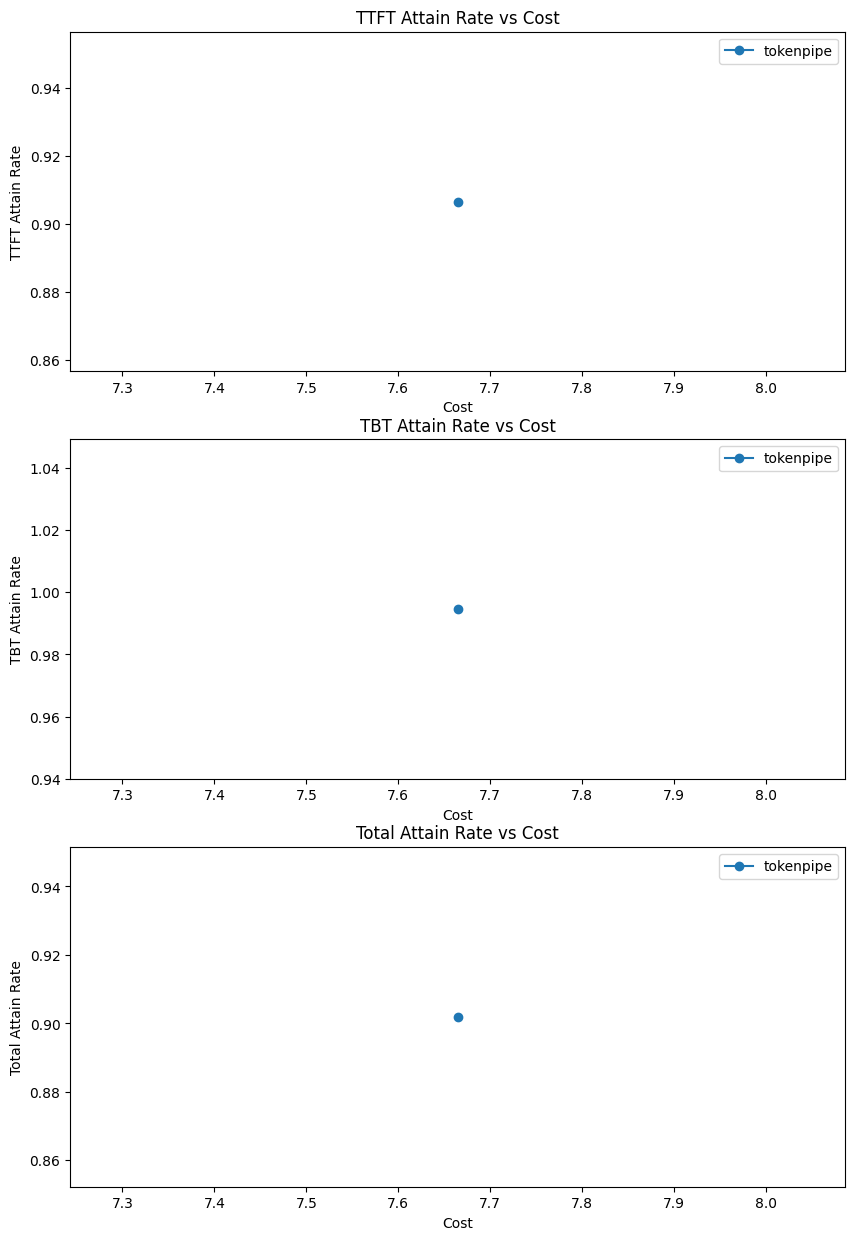

In [12]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
for metric in run_log_dirs_map.keys():
    costs = costs_map[metric]
    ttft_attain_rates = ttft_attain_rates_map[metric]
    tbt_attain_rates = tbt_attain_rates_map[metric]
    total_attain_rates = total_attain_rates_map[metric]
    axes[0].plot(costs, ttft_attain_rates, marker='o', label=metric)
    axes[0].set_title('TTFT Attain Rate vs Cost')
    axes[0].set_xlabel('Cost')
    axes[0].set_ylabel('TTFT Attain Rate')
    axes[0].legend()
    axes[1].plot(costs, tbt_attain_rates, marker='o', label=metric)
    axes[1].set_title('TBT Attain Rate vs Cost')
    axes[1].set_xlabel('Cost')
    axes[1].set_ylabel('TBT Attain Rate')
    axes[1].legend()
    axes[2].plot(costs, total_attain_rates, marker='o', label=metric)
    axes[2].set_title('Total Attain Rate vs Cost')
    axes[2].set_xlabel('Cost')
    axes[2].set_ylabel('Total Attain Rate')
    axes[2].legend()

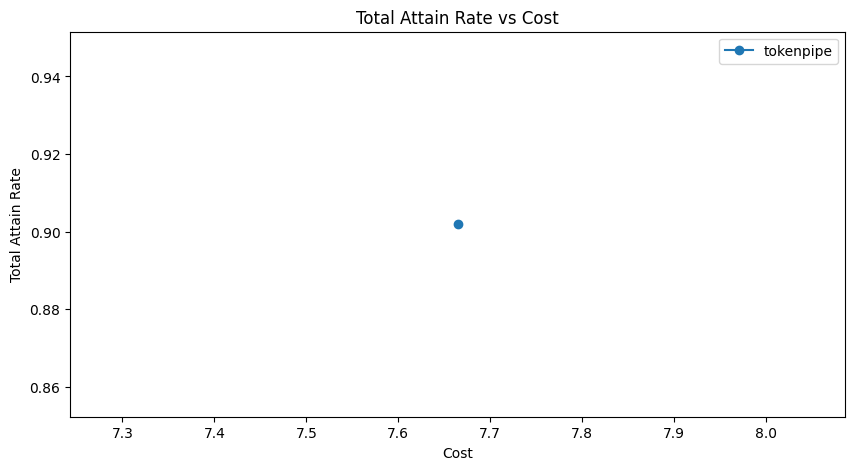

In [13]:

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
for metric in run_log_dirs_map.keys():
    costs = costs_map[metric]
    ttft_attain_rates = ttft_attain_rates_map[metric]
    tbt_attain_rates = tbt_attain_rates_map[metric]
    total_attain_rates = total_attain_rates_map[metric]
    axes.plot(costs, total_attain_rates, marker='o', label=metric)
    axes.set_title('Total Attain Rate vs Cost')
    axes.set_xlabel('Cost')
    axes.set_ylabel('Total Attain Rate')
    axes.legend()